In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

Here I extract the relevant columns and convert zip to string for processing. Many zipcodes have a +4 identifier for delivery routes (e.g. 12345-6789). Since these delivery routes aren't essential to calculating location, I remove these and focus only on the 5 digit zip.

In [10]:
data = pd.read_csv('../data/scorecard/Most-Recent-Cohorts-Full.csv')
data = data.iloc[:, 0:1027]
data = data[['INSTNM', 'ZIP', 'LATITUDE', 'LONGITUDE']].dropna(how='any')
data.columns = ['name', 'zip', 'lat', 'long']
data['zip'] = data['zip'].astype('string')
data['zip'] = data['zip'].str.split('-', expand=True)[0]
len(data)

/home/huy/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,9,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1379,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1412,1413,1427,1428,1431,1432,1503,1517,1532,1533,1534,1535,1536,1537,1538,1539,1540,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1567,1568,1573,1574,1575,1576,1577,1581,1582,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1604,1605,1606,1608,1610,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1636,1638,1640,1643,1644,1648,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1664,1666,1669,1670,1674,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1695,1697,1700,1701,1702,1703,1704,1705,1706,1707,1711,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1844

6189

This functions calculates the distance between two latitudes/longitudes and returns a value in km. I found the code from this stackoverflow: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula. This might be useful if we want to directly calculate the distance from the user to a college they're interested in.

In [11]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

I downloaded the zipcodes from here: https://gist.github.com/abatko/ee7b24db82a6f50cfce02afafa1dfd1e. This zipcode file is from 2018 so it isn't the most updates version. I found an API version that is an alternative to using a non-updated database. However, this requires a precise address input: https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf. I then calculate how many college zip codes in our college database do not have a corresponding entry in the zipcode file. Ideally we'll use this zipcode information to convert from the user's specified location to latitude/longitude for nearest colleges calculations.

In [12]:
zipcodes = pd.read_csv('./data/zipcodes.csv', dtype={'ZIP': object})
zipcodes.columns = ['zip', 'zlat', 'zlong']
zipcodes['zip'] = zipcodes['zip'].astype('string')
sum(data.merge(zipcodes, how='left', on='zip')['zlat'].isna())

272

After looking into building trees with spatial partition for efficient neighbor querying, I found a handy scipy package that implements this. Documentation can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree.

In [13]:
from scipy.spatial import KDTree
tree_kd = KDTree(data[['lat', 'long']])

For the following function, I convert from km to latitude to provide a search value for the scipy KDTree package. I chose to use latitude arbitrarily as latitude and longitude have different values for the same distance (i.e. 10 miles does not have the same latitude and longitude value). Using only either latitude or longitude to calculate radius is somewhat inaccurate as described here: http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates. However, as KDTree takes one radius value as input for query, I decided to move forward with this.

In [14]:
from math import cos, pi

def dist_to_lat(dist, unit="kilometers"):
    if unit=="miles":
        dist *= 1.60934
    return dist*1.60934/110.574

## Testing Query

Define zipcode and mile radius for search.

In [15]:
user_zip = '92804'
user_zip_loc = zipcodes[zipcodes['zip'] == user_zip][['zlat', 'zlong']]
miles_radius = 10

This uses the KDTree query.

In [16]:
query_kd = tree_kd.query_ball_point(user_zip_loc, dist_to_lat(miles_radius, unit="miles"))
kd_method = data.iloc[query_kd[0]]

This calculates the l2-norm distance between the provided zip code and every college in the dataframe.

In [17]:
curr_point = zipcodes[zipcodes['zip'] == user_zip][['zlat', 'zlong']]
print(curr_point)
lat = curr_point['zlat'].values[0]
long = curr_point['zlong'].values[0]
calc_method = data[np.sqrt((data['lat'] - lat)**2 + (data['long'] - long)**2) <= dist_to_lat(miles_radius, "miles")]

            zlat       zlong
30642  33.818271 -117.975017


Confirm that both methods provide the same results:

In [18]:
(kd_method != calc_method).sum()

name    0
zip     0
lat     0
long    0
dtype: int64

## SKLearn's BallTree and KDTree

After discussing with Jordan, two issues came to light: 1. The ability to create custom distance functions and 2. Being able to alter top nearest neighbor choices based on different column weights. I decided to move forward looking into sci-kit learn's nearest neighbor and distance-based tree packages. First I compare the use of sci kit learn's distance-based tree package to see if its result is the same as KD Trees.

In [19]:
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree
from sklearn.neighbors import DistanceMetric

In [20]:
tree_sk = BallTree(data[['lat', 'long']])  

In [21]:
query_sk = tree_sk.query_radius(user_zip_loc, dist_to_lat(miles_radius, unit="miles"))
sk_method = data.iloc[query_sk[0]]
(sk_method.sort_index() != kd_method).sum()

name    0
zip     0
lat     0
long    0
dtype: int64

We will have to rebuild the tree every time we want to incorporate a new custom distance metric. I don't believe we'll use more than minowski distance but here I try a different distance metric (manhattan). Sklearn also provides a few metrics of there owns that we can use including (not surprisingly) manhattan.

In [22]:
def manhattan(x, y):
    return np.sum(np.absolute(x-y))

In [23]:
tree_sk_man = BallTree(data[['lat', 'long']], metric=manhattan)
query_sk_man = tree_sk_man.query_radius(user_zip_loc, dist_to_lat(miles_radius, unit="miles"))
sk_man_method = data.iloc[query_sk_man[0]]

In [24]:
tree_man = BallTree(data[['lat', 'long']], metric=DistanceMetric.get_metric('manhattan'))
query_man = tree_man.query_radius(user_zip_loc, dist_to_lat(miles_radius, unit="miles"))
man_method = data.iloc[query_man[0]]
(sk_man_method != man_method).sum()

name    0
zip     0
lat     0
long    0
dtype: int64

Here I time the creation of new ball trees to see how inefficient it will be to recreate a new tree.

In [25]:
%%time
for i in range(1000):
    BallTree(data[['lat', 'long']])

CPU times: user 2.63 s, sys: 0 ns, total: 2.63 s
Wall time: 2.63 s


In [26]:
%%time
for i in range(1000):
    KDTree(data[['lat', 'long']])

CPU times: user 2.77 s, sys: 0 ns, total: 2.77 s
Wall time: 2.77 s


## SKLearn NN

In [2]:
from sklearn.neighbors import NearestNeighbors

In [4]:
data = pd.read_csv('./data/scorecard/Most-Recent-Cohorts-Full.csv')
columns = pd.read_excel('./data/scorecard/columns-simplified.xlsx')

I drop the irrelevant identification columns as well as change any privacy suppressed and nan values to 0 for now. We may want to figure out a better way to handle these values in the future.

In [43]:
simplified = data[list(columns['VARIABLE NAME'])]
simplified.drop(['UNITID', 'INSTNM', 'INSTURL', 'CITY', 'STABBR', 'ZIP'], axis=1, inplace=True)

/home/huy/.local/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
simplified.columns[(simplified == "PrivacySuppressed").any()]

Index(['COMP_ORIG_YR2_RT', 'COMP_ORIG_YR3_RT', 'COMP_ORIG_YR4_RT',
       'COMP_ORIG_YR6_RT', 'COMP_ORIG_YR8_RT'],
      dtype='object')

In [45]:
simplified[['COMP_ORIG_YR2_RT', 'COMP_ORIG_YR3_RT', 'COMP_ORIG_YR4_RT', 'COMP_ORIG_YR6_RT', 'COMP_ORIG_YR8_RT']]

,COMP_ORIG_YR2_RT,COMP_ORIG_YR3_RT,COMP_ORIG_YR4_RT,COMP_ORIG_YR6_RT,COMP_ORIG_YR8_RT
0,0.036073329391,0.114434330299,0.210526315789,0.28077232502,0.314393939394
1,0.145747707872,0.327259204165,0.461707585196,0.53630239521,0.524893863373
2,PrivacySuppressed,0.0859375,0.162962962963,0.141463414634,0.239726027397
3,0.165609584214,0.313755795981,0.464680851064,0.529255319149,0.485385296723
4,0.026500389712,0.130295763389,0.237909516381,0.284132841328,0.266284896206
...,...,...,...,...,...
6689,0.136350857464,0.163543897216,0.17,0.160021124901,0.147801009373
6690,0.538461538462,0.457142857143,0.448979591837,PrivacySuppressed,PrivacySuppressed
6691,0.630136986301,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed
6692,NaN,NaN,NaN,NaN,NaN


In [46]:
simplified.replace(to_replace="PrivacySuppressed", value = np.nan, inplace=True)
simplified.replace(to_replace=np.nan, value=0, inplace=True)

/home/huy/.local/lib/python3.8/site-packages/pandas/core/frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [47]:
simplified[['COMP_ORIG_YR2_RT', 'COMP_ORIG_YR3_RT', 'COMP_ORIG_YR4_RT', 'COMP_ORIG_YR6_RT', 'COMP_ORIG_YR8_RT']]

,COMP_ORIG_YR2_RT,COMP_ORIG_YR3_RT,COMP_ORIG_YR4_RT,COMP_ORIG_YR6_RT,COMP_ORIG_YR8_RT
0,0.036073329391,0.114434330299,0.210526315789,0.28077232502,0.314393939394
1,0.145747707872,0.327259204165,0.461707585196,0.53630239521,0.524893863373
2,0,0.0859375,0.162962962963,0.141463414634,0.239726027397
3,0.165609584214,0.313755795981,0.464680851064,0.529255319149,0.485385296723
4,0.026500389712,0.130295763389,0.237909516381,0.284132841328,0.266284896206
...,...,...,...,...,...
6689,0.136350857464,0.163543897216,0.17,0.160021124901,0.147801009373
6690,0.538461538462,0.457142857143,0.448979591837,0,0
6691,0.630136986301,0,0,0,0
6692,0,0,0,0,0


In [48]:
neigh = NearestNeighbors()
neigh.fit(simplified)

NearestNeighbors()

In [49]:
simplified = simplified.loc[:,~simplified.columns.duplicated()]

In [50]:
neigh.fit(simplified[['CONTROL', 'LOCALE', 'CIP14BACHL']])

NearestNeighbors()

In [51]:
college_query = neigh.kneighbors(pd.DataFrame([{'CONTROL': 0, 'LOCALE': 22, 'CIP14BACHL': 1}]), return_distance=False)

In [52]:
data.iloc[college_query[0]]

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,GT_THRESHOLD_P10,MD_EARN_WNE_INC1_P10,MD_EARN_WNE_INC2_P10,MD_EARN_WNE_INC3_P10,MD_EARN_WNE_INDEP1_P10,MD_EARN_WNE_INDEP0_P10,MD_EARN_WNE_MALE0_P10,MD_EARN_WNE_MALE1_P10
1482,166692,218100,2181,Massachusetts Maritime Academy,Buzzards Bay,MA,02532-1803,New England Commission on Higher Education,https://www.maritime.edu/,https://www.maritime.edu/netprice/,...,50.0,77731.0,0.9153,NaN,NaN,107188.0,NaN,96539.0,NaN,NaN
2900,214591,332905,3329,Pennsylvania State University-Penn State Erie-...,Erie,PA,16563-0001,Middle States Commission on Higher Education,behrend.psu.edu/,tuition.psu.edu/CostEstimate.aspx,...,12228.0,58866.0,0.8214,48397.0,56055.0,66884.0,48950.0,59218.0,49994.0,66336.0
1518,167987,221000,2210,University of Massachusetts-Dartmouth,North Dartmouth,MA,02747-2300,New England Commission on Higher Education,www.umassd.edu/,https://umassd.studentaidcalculator.com/welcom...,...,128.0,54542.0,0.7889,54536.0,58193.0,63504.0,40750.0,60978.0,54123.0,69010.0
221,110705,132000,1320,University of California-Santa Barbara,Santa Barbara,CA,93106,Western Association of Schools and Colleges Se...,www.ucsb.edu/,finaid.ucsb.edu/net-price-calculator,...,2359.0,64209.0,0.8453,60925.0,67183.0,71665.0,58764.0,67149.0,64201.0,69859.0
2613,204839,310004,3100,Ohio University-Southern Campus,Ironton,OH,45638,Higher Learning Commission,https://www.ohio.edu/southern/,https://npc.collegeboard.org/app/ohio,...,4562.0,46751.0,0.7386,35953.0,46943.0,56032.0,35699.0,49460.0,42012.0,54537.0


Rebuilding the nearest neighbor model is significantly slower than the kdtree or balltree models. However, it may still be fast enough for our use in the project.

In [53]:
%%time
for i in range(100):
    neigh = NearestNeighbors()
    neigh.fit(simplified)

CPU times: user 3.77 s, sys: 0 ns, total: 3.77 s
Wall time: 3.76 s


### Example Filter and Query

In [109]:
### Basic Information

## Input zip -> string
user_zip = '92804'

## Checkbox of the provided majors -> list
degree = ['Engineering', 'Psychology']

## Slider -> tuple of ints
cost_range = (10000, 20000)

## Dropdown of public, private, or both -> string
control = "Public"

In [103]:
## Dropdown of 10, 25, 50, 100, All (None) -> int
miles_radius = 25

## Checkbox certain states -> list of string
states = ["CA", "NY", "OR", "PA", "WA"]

##
weather = []

## Dropdown of religious affiliation or None -> string
religious_affiliation = None

## Checkbox of setting type urban, rural, suburban -> list of string
environment = []

In [57]:
data = pd.read_csv('./data/scorecard/Most-Recent-Cohorts-Full.csv')
columns = pd.read_excel('./data/scorecard/columns-simplified.xlsx')

simplified = data[list(columns['VARIABLE NAME'])]

## Figure out what we want to do with privacy suppressed and nan values later
simplified.replace(to_replace="PrivacySuppressed", value = np.nan, inplace=True)
simplified.replace(to_replace=np.nan, value=0, inplace=True)
simplified = simplified.loc[:,~simplified.columns.duplicated()]

/home/huy/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,9,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1379,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1412,1413,1427,1428,1431,1432,1503,1517,1532,1533,1534,1535,1536,1537,1538,1539,1540,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1567,1568,1573,1574,1575,1576,1577,1581,1582,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1604,1605,1606,1608,1610,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1636,1638,1640,1643,1644,1648,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1664,1666,1669,1670,1674,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1695,1697,1700,1701,1702,1703,1704,1705,1706,1707,1711,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1844

In [58]:
## Description: Finds colleges within a specified radius in miles of the provided zip code
## Inputs:
##   df - dataframe of college data
##   user_zip - provided zipcode
##   zip_to_lat - dataframe converting zipcodes to latitude/longitude
##   miles - radius in miles around user_zip, if none returns all colleges
## Outputs:
##   returns filtered college dataframe based on location

def radius_filter(df, user_zip, zip_to_lat, miles = None):
    if not miles:
        return df
    
    user_zip_loc = zip_to_lat[zip_to_lat['zip'] == user_zip][['zlat', 'zlong']]
    
    if user_zip_loc.empty:
        raise ValueError('Invalid zipcode input')
    
    tree = BallTree(df[['LATITUDE', 'LONGITUDE']])  
    query = tree.query_radius(user_zip_loc, (miles*1.60934/110.574))
    return df.iloc[query[0]]

In [59]:
## Description: Finds the corresponding column name for the provided degrees and returns them as a list.
##              If no degree is specified, returns all the column names.
## Inputs:
##   df - dataframe of college data
##   columns - dataframe from columns-simplified.xlsx without modifications
##   degree - list of interested majors
## Outputs:
##   returns filtered college dataframe based on interested majors

def degree_filter(df, columns, degree):
    
    temp_col = columns[columns['VARIABLE NAME'].str.contains('CIP')]
    var_name = temp_col['VARIABLE NAME']
    var_name = var_name.astype('string')
    
    deg_cols = []
    if not degree:
        deg_cols = list(var_name)
    else:
        if type(degree) != list:
            raise TypeError("degree input must be a list")
        degs = temp_col['NAME OF DATA ELEMENT'].str.split('Bachelor\'s degree in ', expand=True).iloc[:,1]
        degs = degs.str.split('.', expand=True).iloc[:,0]
        degs = degs.astype('string')
        degree_dict = dict(zip(degs, var_name))
        for deg in degree:
            deg_cols.append(degree_dict[deg])
    print(deg_cols)
    return df[df[deg_cols].all(axis=1)]

In [92]:
## Description: Finds colleges which are within the specified cost range. Uses average cost of attendance 
##              which contains tuition and fees, books and supplies, and living expenses. Does not take
##              into account in-state vs. out-of-state.
## Inputs:
##   df - dataframe of college data
##   cost_range - tuple of cost ranges
## Outputs:
##   returns filtered college dataframe based on cost range
def cost_filter(df, cost_range=(0,0)):
    if cost_range == (0,0):
        return df
    return df[(df['COSTT4_A'] >= cost_range[0]) & (df['COSTT4_A'] <= cost_range[1])]

In [91]:
## Description: Finds colleges within a list of colleges.
## Inputs:
##   df - dataframe of college data
##   states - a list of state abbreviations (can be empty)
## Outputs:
##   returns filtered college dataframe based on state selection
def states_filter(df, states=[]):
    if len(states) == 0:
        return df
    return df[df['STABBR'].isin(states)]

In [98]:
## Description: Finds colleges based on private or public.
## Inputs:
##   df - dataframe of college data
##   control - a string denoting Public, Private, or Both
## Outputs:
##   returns filtered college dataframe based on control
def control_filter(df, control="Both"):
    if control == "Public":
        return df[df['CONTROL'] == 1]
    elif control == "Private":
        return df[df['CONTROL'] != 1]
    elif control == "Both":
        return df
    else:
        raise ValueError('Control must be either Public, Private, or Both')

In [110]:
control_filter(states_filter(cost_filter(degree_filter(simplified, columns, degree), cost_range), states), control)

['CIP14BACHL', 'CIP42BACHL']


,UNITID,INSTNM,CITY,STABBR,ZIP,INSTURL,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,...,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_NWNE_1YR,COUNT_WNE_1YR,BOOKSUPPLY,ROOMBOARD_ON,OTHEREXPENSE_ON,ROOMBOARD_OFF,OTHEREXPENSE_OFF
201,110486,California State University-Bakersfield,Bakersfield,CA,93311-1099,www.csub.edu/,1,1,3,4,...,40335.0,24507.0,61339.0,59.0,844.0,2058.0,12900.0,2654.0,13215.0,3283.0
203,110510,California State University-San Bernardino,San Bernardino,CA,92407-2393,www.csusb.edu/,1,1,3,4,...,42079.0,26404.0,61848.0,282.0,4377.0,1971.0,13435.0,2568.0,16189.0,2982.0
207,110556,California State University-Fresno,Fresno,CA,93740,www.fresnostate.edu/,1,1,3,4,...,42306.0,26662.0,61240.0,268.0,4763.0,1972.0,10587.0,2568.0,15084.0,2982.0
208,110565,California State University-Fullerton,Fullerton,CA,92831-3599,www.fullerton.edu/,1,1,3,4,...,45657.0,29559.0,64185.0,574.0,9742.0,2058.0,15852.0,3209.0,16189.0,3283.0
210,110583,California State University-Long Beach,Long Beach,CA,90840-0115,www.csulb.edu/,1,1,3,4,...,46059.0,29143.0,65942.0,605.0,9941.0,2058.0,13158.0,3208.0,15056.0,3282.0
211,110592,California State University-Los Angeles,Los Angeles,CA,90032-8506,www.calstatela.edu/,1,1,3,4,...,42517.0,26698.0,60696.0,357.0,5562.0,2058.0,15992.0,3209.0,16189.0,3283.0
212,110608,California State University-Northridge,Northridge,CA,91330,https://www.csun.edu/,1,1,3,4,...,42178.0,26196.0,61095.0,571.0,9351.0,2058.0,11328.0,3282.0,16188.0,3282.0
2118,190512,CUNY Bernard M Baruch College,New York,NY,10010,www.baruch.cuny.edu/,1,1,3,4,...,55554.0,33797.0,77245.0,274.0,4247.0,1364.0,18953.0,5504.0,15577.0,5504.0
2122,190558,College of Staten Island CUNY,Staten Island,NY,10314,www.csi.cuny.edu/,1,1,3,4,...,39590.0,22466.0,61494.0,152.0,1660.0,1364.0,18695.0,5504.0,15577.0,5504.0
2123,190567,CUNY City College,New York,NY,10031,www.ccny.cuny.edu/,1,1,3,4,...,45588.0,26539.0,66257.0,188.0,2769.0,1364.0,16164.0,5504.0,15577.0,5504.0


## Sklearn NN 2 with UI/Filters

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
## Function to map input major names with output column names in dataframe
def degree_dicts(df, columns):
    temp_col = columns[columns['VARIABLE NAME'].str.contains('CIP')]
    var_name = temp_col['VARIABLE NAME']
    var_name = var_name.astype('string')
    
    degs = temp_col['NAME OF DATA ELEMENT'].str.split('Bachelor\'s degree in ', expand=True).iloc[:,1]
    degs = degs.str.split('.', expand=True).iloc[:,0]
    degs = degs.astype('string')
    return dict(zip(degs, var_name))

In [4]:
data = pd.read_csv('../data/final.csv')
columns = pd.read_excel('../data/scorecard/columns-simplified.xlsx')

In [6]:
school_dict = {}

## string
# mandatory
major = "Engineering"
school_dict[degree_dicts(data, columns)[major]] = []
school_dict[degree_dicts(data, columns)[major]].append(1)

## importance
school_dict[degree_dicts(data, columns)[major]].append(5)

## Don't have information -> probably a float
# mandatory
# GPA = None

## integer
zipcode = 92804

## integer
# mandatory
sat = 1400
school_dict['SAT_AVG'] = [] 
school_dict['SAT_AVG'].append(sat)

# importance
school_dict['SAT_AVG'].append(5)

act = 30
school_dict['ACTCMMID'] = [] 
school_dict['ACTCMMID'].append(act)

# importance
school_dict['ACTCMMID'].append(5)

## list of strings
# need to handle multiple states situation
states = ["CA", "NY"]
states_imp = 3
for state in states:
    school_dict[state] = []
    school_dict[state].append(1)
    school_dict[state].append(states_imp)

# Abhishek finishing up -> not sure dependent on abhishek
# weather = None

## Selection (need to define brackets) -> 2500, 5000, 10000, 15000+
size = 2500
size_imp = 4

school_dict['UGDS'] = []
school_dict['UGDS'].append(size)
school_dict['UGDS'].append(size_imp)

## integer 1 to 4 (1=city, 2=suburb, 3=town, 4=rural)
# needs special handling to handle 11, 12, 13, 14 case for ex
environment = 1
environment_imp = 2
school_dict['LOCALE_' + str(environment)] = []
school_dict['LOCALE_' + str(environment)].append(1)
school_dict['LOCALE_' + str(environment)].append(environment_imp)

## Need to talk to Jordan about this
cost = None

In [7]:
## Change locale to 4 categories
data['LOCALE'] = (data['LOCALE'] / 10).astype(int)

## Fill non-religious schools with value
data['RELAFFIL'].fillna(-1, inplace=True)

## The last 6-7 schools have weird nan values so I don't use them
data.dropna(how='any', inplace=True)

## Change state to dummy variable
temp = pd.get_dummies(data, prefix = '', prefix_sep = '', columns=['STABBR'])

## Change locale to dummy variable
temp = pd.get_dummies(temp, columns=['LOCALE'])

## Get the important columns
temp = temp[school_dict.keys()]

## Normalize columns between 0 and 1 for both data and query point
## Need to handle highly skewed coluns (like size)
for col in temp.columns:
    school_dict[col] = school_dict[col] / temp[col].max()
    temp[col] = temp[col] / temp[col].max()

In [17]:
query = pd.DataFrame(pd.DataFrame(school_dict).iloc[0, :]).T
importance = pd.DataFrame(school_dict).iloc[1, :]

In [18]:
### Selecting importance for features
weather_imp = None
cost_imp = None
selectivity_imp = None
quality_imp = None
return_imp = None

In [22]:
def custom_dist(x, y, col_imp):
    sum_dist = 0
    for i in range(len(x)):
        sum_dist += col_imp[i]*(x[i] - y[i])**2
    return np.sqrt(sum_dist)

In [23]:
neigh = NearestNeighbors(metric=custom_dist, metric_params = {'col_imp': importance})
neigh.fit(temp)

NearestNeighbors(metric=<function custom_dist at 0x7ff0e6978670>,
                 metric_params={'col_imp': CIP14BACHL    2.500000
SAT_AVG       0.003211
ACTCMMID      0.138889
CA            3.000000
NY            3.000000
UGDS          0.000041
LOCALE_1      2.000000
Name: 1, dtype: float64})

In [24]:
data.loc[neigh.kneighbors(query, 10, return_distance=False)[0], ]

,UNITID,INSTNM,CITY,STABBR,ZIP,INSTURL,MAIN,NUMBRANCH,CONTROL,REGION,...,COST_INSTATE_OFFCAMPUS,COST_OUTSTATE_ONCAMPUS,COST_OUTSTATE_OFFCAMPUS,FINAID1,FINAID2,FINAID3,FINAID4,FINAID5,CLIMATE_ZONE,GPA_BOTTOM_TEN_PERCENT
180,122931,Santa Clara University,Santa Clara,CA,95053,www.scu.edu/,1,2,2,8,...,75963.00000,74829.0,75963.00000,48979.0,52386.0,46487.0,39973.0,18974.0,Csb,3.4
1058,191241,Fordham University,Bronx,NY,10458,www.fordham.edu/,1,1,2,2,...,70789.00000,76891.0,70789.00000,45391.0,43598.0,35989.0,31591.0,25804.0,Cfa,3.3
103,110680,University of California-San Diego,La Jolla,CA,92093,www.ucsd.edu/,1,1,1,8,...,33984.00000,63603.0,63738.00000,23154.0,22460.0,18363.0,12229.0,4376.0,BSk,3.5
1164,196866,Union College,Schenectady,NY,12308-2311,www.union.edu/,1,1,2,2,...,69963.00000,73410.0,69963.00000,56561.0,55847.0,50295.0,40490.0,26151.0,Dfb,2.8
1111,194824,Rensselaer Polytechnic Institute,Troy,NY,12180-3590,www.rpi.edu/,1,2,2,2,...,73132.62667,73816.0,73132.62667,49336.0,47637.0,45201.0,37952.0,28129.0,Dfb,3.5
140,117946,Loyola Marymount University,Los Angeles,CA,90045-2659,https://www.lmu.edu/,1,1,2,8,...,73012.00000,70446.0,73012.00000,34650.0,31851.0,32733.0,26053.0,17748.0,BSk,3.2
105,110714,University of California-Santa Cruz,Santa Cruz,CA,95064-1011,www.ucsc.edu/,1,1,1,8,...,33734.00000,67051.0,63488.00000,25243.0,24322.0,20862.0,13376.0,3395.0,Csb,3.2
171,122436,University of San Diego,San Diego,CA,92110-2492,www.sandiego.edu/,1,1,2,8,...,73514.00000,70999.0,73514.00000,44555.0,43594.0,41091.0,36449.0,25139.0,BSk,3.2
100,110653,University of California-Irvine,Irvine,CA,92697,www.uci.edu/,1,1,1,8,...,33162.00000,65117.0,62916.00000,23767.0,22952.0,19677.0,13474.0,3484.0,Csa,3.3
1114,195030,University of Rochester,Rochester,NY,14627-0011,https://www.rochester.edu/,1,1,2,2,...,73800.98000,75190.0,73800.98000,57397.0,58213.0,49062.0,43379.0,27989.0,Dfb,3.5


## Size Comparisons

array([[<AxesSubplot:title={'center':'UGDS'}>]], dtype=object)

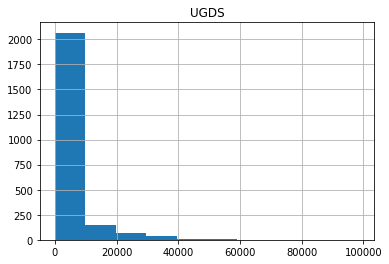

In [6]:
data.hist(column='UGDS')

array([[<AxesSubplot:title={'center':'UGDS'}>]], dtype=object)

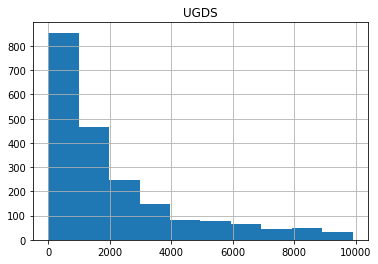

In [7]:
data[data['UGDS'] <= 10000].hist(column='UGDS')

array([[<AxesSubplot:title={'center':'UGDS'}>]], dtype=object)

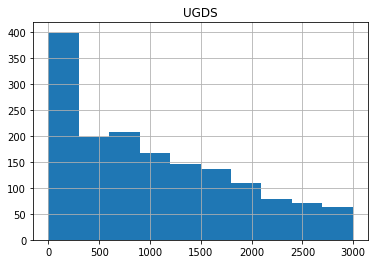

In [8]:
data[data['UGDS'] <= 3000].hist(column='UGDS')

## Environment Brackets

11	City: Large (population of 250,000 or more) <br>
12	City: Midsize (population of at least 100,000 but less than 250,000) <br>
13	City: Small (population less than 100,000) <br>
21	Suburb: Large (outside principal city, in urbanized area with population of 250,000 or more) <br>
22	Suburb: Midsize (outside principal city, in urbanized area with population of at least 100,000 but less than 250,000) <br>
23	Suburb: Small (outside principal city, in urbanized area with population less than 100,000) <br>
31	Town: Fringe (in urban cluster up to 10 miles from an urbanized area) <br>
32	Town: Distant (in urban cluster more than 10 miles and up to 35 miles from an urbanized area) <br>
33	Town: Remote (in urban cluster more than 35 miles from an urbanized area) <br>
41	Rural: Fringe (rural territory up to 5 miles from an urbanized area or up to 2.5 miles from an urban cluster) <br>
42	Rural: Distant (rural territory more than 5 miles but up to 25 miles from an urbanized area or more than 2.5 and up to 10 miles from an urban cluster) <br>
43	Rural: Remote (rural territory more than 25 miles from an urbanized area and more than 10 miles from an urban cluster) <br>


## Cost Comparisons

I can either use the overall costt4_a column but would need jordan to reinclude that, or I need to ask for income information in the UI to get financial aid from the corresponding columns and subtract that from the cost. I also need to ask about in-state/out-of-state and on-campus/off-campus to use the right cost column for analysis.